# Part 2B: Data Modelling (Imbalanced Dataset)

In this notebook, we will be following through the entire data modelling process from end-to-end.

This includes:
1. Data pre-processing
2. Analysing the correlation of features
3. Feature engineering
4. Model fitting
5. Hyperparameter tuning
6. Model evaluation

## Import libraries

In [1]:
# visualisation imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# model imports
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# tabulate imports
from tabulate import tabulate

# imblearn imports
from imblearn.over_sampling import SMOTE, ADASYN

## Import data

Source: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?resource=download

We have obtained the following three datasets from the above source:
1. diabetes_012_health_indicators_BRFSS2015.csv
    - A clean dataset of 253,680 survey responses to the CDC's BRFSS2015.
    - The target variable `Diabetes_012` has 3 classes. 0 is for no diabetes or only during pregnancy, 1 is for prediabetes, and 2 is for diabetes.
    - There is class imbalance in this dataset.
    - This dataset has 21 feature variables
2. diabetes_binary_5050split_health_indicators_BRFSS2015.csv
    - A clean dataset of 70,692 survey responses to the CDC's BRFSS2015.
    - It has an equal 50-50 split of respondents with no diabetes and with either prediabetes or diabetes.
    - The target variable `Diabetes_binary` has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes.
    - This dataset has 21 feature variables and is balanced.
3. diabetes_binary_health_indicators_BRFSS2015.csv
    - A clean dataset of 253,680 survey responses to the CDC's BRFSS2015.
    - The target variable `Diabetes_binary` has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes.
    - This dataset has 21 feature variables and is not balanced.

In our initial exploration, we used both datasets #2 and #3 to evaluate model performance and runtime complexity.
Due to dataset #3's significant class imbalance, majority of the model evaluation metrics are below 0.7 even after tuning.
Additionally, since dataset #3 is more than 3x the size of dataset #2, the runtime is also approximately 2-3x longer.

With these considerations, our team decided to proceed with dataset #2, as seen in the Part 2A notebook.
The exploration using dataset #3 can be found in this part 2B notebook.

In [2]:
df = pd.read_csv("./data/diabetes_binary_health_indicators_BRFSS2015.csv")

In [3]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
df.shape

(253680, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

There are no categorical variables so one-hot encoding is not needed.

## 1. Data pre-processing

In [6]:
# change columns to lowercase
df.columns = df.columns.str.lower()
df.columns

Index(['diabetes_binary', 'highbp', 'highchol', 'cholcheck', 'bmi', 'smoker',
       'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies',
       'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth',
       'menthlth', 'physhlth', 'diffwalk', 'sex', 'age', 'education',
       'income'],
      dtype='object')

All column names are converted to lowercase for easier pre-processing.

Column names are not renamed to maintain easy readability.

In [7]:
# check for distribution of diabetes vs. non-diabetes
df['diabetes_binary'].value_counts(normalize=True) * 100

diabetes_binary
0.0    86.066698
1.0    13.933302
Name: proportion, dtype: float64

As mentioned, this dataset is very imbalanced between

`1`: individuals with diabetes (minority class)

`0`: individuals with no diabetes or with pre-diabetes (majority class)

In [8]:
# check for null values
df.isna().sum()

diabetes_binary         0
highbp                  0
highchol                0
cholcheck               0
bmi                     0
smoker                  0
stroke                  0
heartdiseaseorattack    0
physactivity            0
fruits                  0
veggies                 0
hvyalcoholconsump       0
anyhealthcare           0
nodocbccost             0
genhlth                 0
menthlth                0
physhlth                0
diffwalk                0
sex                     0
age                     0
education               0
income                  0
dtype: int64

The dataset does not contain any null values, so no further action is needed to drop rows or fill null values.

## 2. Analysing correlation of features

A correlation heatmap is generated to examine the relationships between different variables in the dataset. This helps identify redundant or highly correlated features, which can affect the performance of the model.

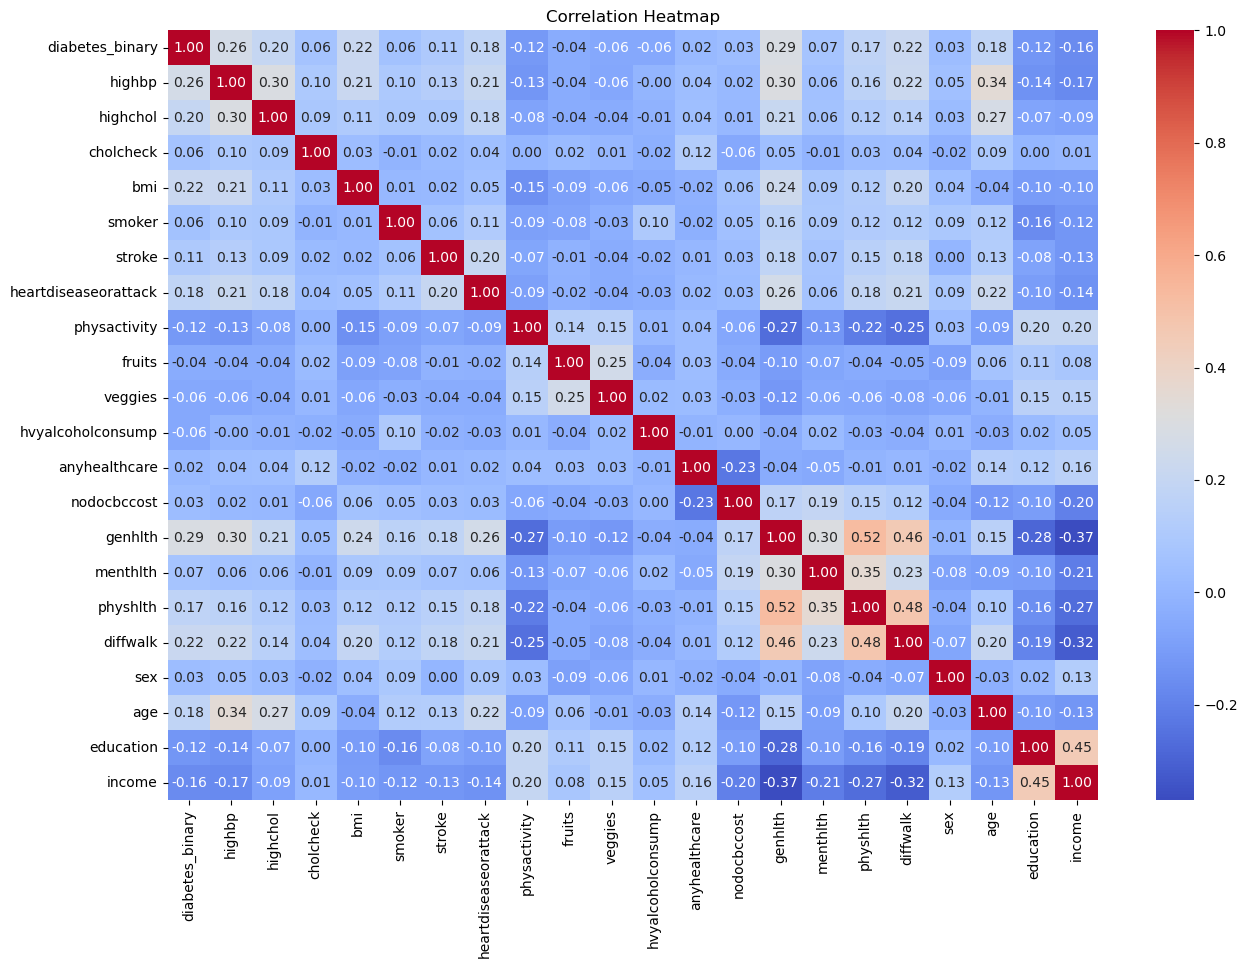

In [9]:
# correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

For the purpose of this analysis:
- Correlation scores of between -0.1 to 0.1 are deemed as weakly correlated
- Correlation scores < -0.35 and > 0.35 are deemed as strongly correlated

## 3. Feature engineering

From the heatmap, focusing on the dependent variable `diabetes_binary`, we can infer the following:
- (`diabetes_binary` x `high_bp`), (`diabetes_binary` x `genhlth`), (`genhlth` x `physhlth`), (`genhlth` x `diffwalk`), (`menhlth` x `physhlth`), (`physhlth` x `diffwalk`) and (`education` x `income`) are strongly correlated. We will explore some of these relationships as interaction terms.

- `smoker`, `physactivity`, `fruits`, `veggie`, `hvyalcoholconsump`, `anyhealthcare`, `nodocbccost`, `menthlth` and `sex` are weakly correlated with `diabetes_binary`. These features will be dropped.

In [10]:
# create interaction terms
df['bmi_highbp_diffwalk_interaction'] = df['bmi'] * df['highbp'] * df['diffwalk']
df['age_highchol_heartdiseaseorattack_interaction'] = df['age'] * df['highchol'] * df['heartdiseaseorattack']
df['genhlth_physhlth_interaction'] = df['genhlth'] * df['physhlth']

In [11]:
# drop columns that are poorly correlated with 'diabetes_binary'
df.drop(['smoker', 'fruits', 'veggies', 'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'menthlth', 'sex'], axis=1, inplace=True)

In [12]:
df

,diabetes_binary,highbp,highchol,cholcheck,bmi,stroke,heartdiseaseorattack,physactivity,genhlth,physhlth,diffwalk,age,education,income,bmi_highbp_diffwalk_interaction,age_highchol_heartdiseaseorattack_interaction,genhlth_physhlth_interaction
0,0.0,1.0,1.0,1.0,40.0,0.0,0.0,0.0,5.0,15.0,1.0,9.0,4.0,3.0,40.0,0.0,75.0
1,0.0,0.0,0.0,0.0,25.0,0.0,0.0,1.0,3.0,0.0,0.0,7.0,6.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,5.0,30.0,1.0,9.0,4.0,8.0,28.0,0.0,150.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,1.0,2.0,0.0,0.0,11.0,3.0,6.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,1.0,2.0,0.0,0.0,11.0,5.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,3.0,5.0,0.0,5.0,6.0,7.0,0.0,0.0,15.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,4.0,0.0,1.0,11.0,2.0,4.0,18.0,0.0,0.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,5.0,2.0,0.0,0.0,0.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,3.0,0.0,0.0,7.0,5.0,1.0,0.0,0.0,0.0


## Train-test split

In train-test split, stratification ensures that the proportion of classes in the training and testing sets are similar to that of the original dataset.

For such an imbalanced dataset such as the one we are working with, stratifying helps to ensure that both training and testing sets represent the overall class distribution accurately.

Maintaining the same class distribution across splits helps prevent bias and ensures more reliable model evaluation and performance estimation.

In [13]:
X = df.drop('diabetes_binary', axis=1)
y = df['diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify

### Addressing class imbalance further

SMOTE (Synthetic Minority Over-sampling Technique) and ADASYN (Adaptive Synthetic Sampling) are both methods to address class imbalance by creating synthetic samples for the minority class.

However, ADASYN improves upon SMOTE by adaptively generating more synthetic samples for minority instances that are harder to classify, making it more effective in challenging scenarios.

In [14]:
# Apply SMOTE to over-sample the minority class
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [15]:
# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

We adjust the class weights to penalize misclassifications of the minority class more heavily. This can be done using the `class_weight` parameter for "Logistic Regression".

In [16]:
# Define class weights
# Initialise classifiers below with class weighting
class_weights = {0: 0.15, 1: 0.86}  # Assign higher weight to minority class

## 4. Model fitting

The following classification models are selected as they are suitable for binary classification.

Each model's parameters are selected based on their typical usage and characteristics:

1. Logistic Regression:
   - `solver='liblinear'`: Suitable for small datasets and binary classification problems.
   - `class_weights`: To assign heavier weight to minority class and smaller weight to majority class.
   - `random_state=42`: Sets the random seed for reproducibility.

2. Random Forest:
   - `random_state=42`: Sets the random seed for reproducibility.

3. XGBoost:
   - `eval_metric='logloss'`: Sets the evaluation metric to log loss for binary classification.
   - `random_state=42`: Sets the random seed for reproducibility.

4. Decision Tree:
   - `random_state=42`: Sets the random seed for reproducibility.

5. Gradient Boosting Machine:
   - `random_state=42`: Sets the random seed for reproducibility.

6. Support Vector Machine:
   - `random_state=42`: Sets the random seed for reproducibility.

7. Neural Network (`MLPClassifier`):
   - `max_iter=200`: Maximum number of iterations for optimization.
   - `solver='adam'`: Optimization algorithm for training the neural network.
   - `random_state=42`: Sets the random seed for reproducibility.

These parameter choices are based on common practices and default settings that work well for many scenarios.

Note:
The Neural Network modelling experimentation was done before Neural Networks was formally covered in class. `MLPClassifier` was chosen as it is a simpler and more straightforward option for building and training a basic MLP (multi-layer perceptron) classifier, while `Keras` provides a more powerful and flexible framework for building and training complex neural network architectures, with a wider range of features and functionality.

In terms of implementation, `MLPClassifier` is also a lot more straightforward.
- `MLPClassifier` follows the scikit-learn API, where you create an instance of the class, configure the parameters, and then call the fit() method to train the model.
- On the other hand, `keras` follows a more modular approach, where you
   - first define the layers of the neural network, 
   - then compile the model with the desired optimizer and loss function, and
   - finally, call the fit() method to train the model.

In [17]:
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', class_weight=class_weights, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boost': GradientBoostingClassifier(random_state=42),
    #'Support Vector Machine': SVC(random_state=42),
    'Neural Network': MLPClassifier(max_iter=200, solver='adam', random_state=42)
}

The code below evaluates multiple machine learning models using cross-validation and test data. It iterates over each model in the `models` dictionary, trains them on the training data, calculates various evaluation metrics such as accuracy, precision, sensitivity, specificity, and F1-score using both cross-validation and test data.

These metrics are then stored in dictionaries (`baseline_cv_scores` and `baseline_metric_scores`) and lists (`cv_results` and `metric_results`). Finally, the results are printed in tabular format using the `tabulate` function from the `tabulate` library.

The first table displays train scores, test scores, and cross-validation scores for each model, while the second table shows detailed metrics (`Accuracy`, `Precision`, `Sensitivity`, `Specificity`, `F1-Score`) for each model.

For our binary classification problem, 
- `Sensitivity` measures the proportion of true positive predictions (correctly predicted instances of diabetes) among all actual positive instances (true positives and false negatives).

- `Precision` measures the proportion of true positive predictions (correctly predicted instances of diabetes) among all instances predicted as positive.

Hence, we are looking at maximising `Sensitivity` in order to reduce the occurrences of False Negatives (i.e. individuals with high risk of diabetes not being identified as such). To a lesser degree, we also want to maximise `Precision`.

In [18]:
# Dictionary to store baseline scores
baseline_cv_scores = {}
baseline_metric_scores = {}

# List to store results for tabulate
cv_results = []
metric_results = []

# Fitting models and calculating baseline scores
for name, model in models.items():
    # Print progress statement
    print(f"Fitting {name}")

    # Train model on training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Calculate train score
    train_score = model.score(X_train_resampled, y_train_resampled)
    
    # Calculate test score
    test_score = model.score(X_train_resampled, y_train_resampled)
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)
    cv_score_mean = cv_scores.mean()
    
    # Store scores in dictionary
    baseline_cv_scores[name] = {'Train Score': train_score, 'Test Score': test_score, 'CV Score': cv_score_mean}

    # Append results for tabulate
    cv_results.append((name, train_score, test_score, cv_score_mean))

    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate classification report
    # report = classification_report(y_test, y_pred, output_dict=True)

    # Extract metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    pre_tuning_accuracy = accuracy_score(y_test, y_pred)
    pre_tuning_precision = precision_score(y_test, y_pred)
    pre_tuning_sensitivity = recall_score(y_test, y_pred)
    pre_tuning_specificity = tn / (tn + fp)
    pre_tuning_f1 = f1_score(y_test, y_pred)
    
    # Store scores in dictionary
    baseline_metric_scores[name] = {'Accuracy': pre_tuning_accuracy, 'Precision': pre_tuning_precision, 'Sensitivity': pre_tuning_sensitivity, 'Specificity': pre_tuning_specificity, 'F1-Score': pre_tuning_f1}

    # Append results for tabulate
    metric_results.append((name, pre_tuning_accuracy, pre_tuning_precision, pre_tuning_sensitivity, pre_tuning_specificity, pre_tuning_f1))

# Print output in table format
print('\n')
print(tabulate(cv_results, headers=["Model", "Train Score", "Test Score", "Cross-Validation Score"]))
print('\n')
print(tabulate(metric_results, headers=["Model", "Accuracy", "Precision", "Sensitivity", "Specificity", "F1-Score"]))

Fitting Logistic Regression
Fitting Random Forest
Fitting XGBoost
Fitting Decision Tree
Fitting Gradient Boost
Fitting Neural Network


Model                  Train Score    Test Score    Cross-Validation Score
-------------------  -------------  ------------  ------------------------
Logistic Regression       0.647188      0.647188                  0.647323
Random Forest             0.980486      0.980486                  0.890634
XGBoost                   0.910395      0.910395                  0.886514
Decision Tree             0.980492      0.980492                  0.863568
Gradient Boost            0.87405       0.87405                   0.857781
Neural Network            0.806179      0.806179                  0.807768


Model                  Accuracy    Precision    Sensitivity    Specificity    F1-Score
-------------------  ----------  -----------  -------------  -------------  ----------
Logistic Regression    0.394592     0.184732       0.980054       0.299815    0.310868
R

Code doesn't finish running even after 280 minutes and stalls at Support Vector Machine. SVM model fitting process is too computationally expensive, so it is left out.

Out of the 6 remain models, XGBoost, Gradient Boost and Neural Network seem to do well on unseen data (train scores are close to the cross-validation scores). Random Forest and Decision Tree, however, seem to be overfitting (train scores are much greater than the cross-validation scores).

All in all, none of the 6 models have a good balance of the other performance metrics:
- Logistic Regression has an extremely high `Sensitivity` score but does poorly for all other metrics.
- Random Forest, XGBoost, Decision Tree, Gradient Boost and Neural Network all have high `Accuracy` and `Specificity` scores but they do poorly for all other metrics.

Out of XGBoost, Gradient Boost and Neural Network, we will try tuning Gradient Boost as it has the highest `Sensitivity` score which we are trying to maximise.

## 5. Hyperparameter tuning

For tuning Gradient Boost, we perform both `GridSearchCV` and `RandomSearchCV`.
- `GridSearchCV` performs an exhaustive search over all combinations of hyperparameters specified in a grid.
- `RandomSearchCV` randomly samples hyperparameter combinations from specified distributions or ranges.

Random search is typically more efficient for high-dimensional search spaces or when not all hyperparameters are equally important.

#### GridSearchCV

In [19]:
# Define the list of models to be tuned
models_to_tune = ['Gradient Boost']

# Define hyperparameters grid for each model
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10],'penalty': ['l1', 'l2'],'solver': ['liblinear', 'lbfgs', 'sag'],'max_iter': [100, 200, 300]},
    'Gradient Boost': {'n_estimators': [100, 200, 300],'learning_rate': [0.01, 0.1, 0.2],'max_depth': [3, 4, 5]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Neural Network': {'hidden_layer_sizes': [(10,), (50,), (100,)], 'activation': ['relu', 'tanh'], 'alpha': [0.1, 1.0]}
}

# Perform hyperparameter tuning only for the specified models
tuned_models_gs = {}

for name, model in models.items():
    if name in models_to_tune:
        print(f"Hyperparameter tuning for {name}...")
        # Define grid search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], cv=5, scoring='recall', verbose=2, n_jobs=-1)
        
        # Perform grid search
        grid_search.fit(X_train, y_train)
        
        # Get best estimator
        best_model_gs = grid_search.best_estimator_

        # Best parameters and score
        print("Best Parameters:", grid_search.best_params_)
        print("Best Score:", grid_search.best_score_)
        print("Best Model:", grid_search.best_estimator_)
        
        # Store best model
        tuned_models_gs[name] = best_model_gs

    else:
        # For models not in the specified list, continue
        continue

Hyperparameter tuning for Gradient Boost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  22.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  22.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  23.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  23.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  23.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  49.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  49.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  49.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  55.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  57.0s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=  39.1s
[CV

#### RandomSearchCV

In [20]:
# Define the list of models to be tuned
models_to_tune = ['Gradient Boost']

# Define hyperparameters grid for each model
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10],'penalty': ['l1', 'l2'],'solver': ['liblinear', 'lbfgs', 'sag'],'max_iter': [100, 200, 300]},
    'Gradient Boost': {'n_estimators': [100, 200, 300],'learning_rate': [0.01, 0.1, 0.2],'max_depth': [3, 4, 5]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Neural Network': {'hidden_layer_sizes': [(10,), (50,), (100,)], 'activation': ['relu', 'tanh'], 'alpha': [0.1, 1.0]}
}

# Perform hyperparameter tuning only for the specified models
tuned_models_rs = {}

for name, model in models.items():
    if name in models_to_tune:
        print(f"Hyperparameter tuning for {name}...")
        # Define random search
        random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid[name], n_iter=10, cv=5, scoring='recall', verbose=2, n_jobs=-1)
        
        # Perform random search
        random_search.fit(X_train, y_train)
        
        # Get best estimator
        best_model_rs = random_search.best_estimator_

        # Best parameters and score
        print("Best Parameters:", random_search.best_params_)
        print("Best Score:", random_search.best_score_)
        print("Best Model:", random_search.best_estimator_)
        
        # Store best model
        tuned_models_rs[name] = best_model_rs

    else:
        # For models not in the specified list, continue
        continue

Hyperparameter tuning for Gradient Boost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=  29.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=  29.7s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=  29.8s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=  33.1s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=  32.8s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time= 2.3min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time= 2.3min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time= 2.3min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time= 2.3min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time= 2.3min
[CV]

Both `GridSearchCV` and `RandomSearchCV` caused `Sensitivity` score to drop instead of increase.

`Sensitivity` score before tuning: 0.467

Best `Sensitivity` score after tuning with `GridSearchCV`: 0.164

Best `Sensitivity` score after tuning with `RandomSearchCV`: 0.162

We will use the best model from from `GridSearchCV` for model evaluation due to the higher `Sensitivity` score after tuning.

## 6. Model evaluation

Model evaluation assesses the performance of the trained model on unseen data.

This includes calculating various metrics such as `Accuracy`, `Precision`, `Sensitivity`, `Specificity`, and `F1-Score` for classification tasks. The goal is to determine how well the model generalizes to new data and whether it meets the desired performance criteria.

The values of TP/TN/FP/FN, along with a confusion matrix, are generated for our reference.

We also want to confirm that the corresponding values are assigned to TP/TN/FP/FN correctly.

In [21]:
post_tuning_model = tuned_models_gs['Gradient Boost']
y_pred_new = post_tuning_model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_new).ravel()

print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

True Positives: 1117
True Negatives: 42741
False Positives: 926
False Negatives: 5952


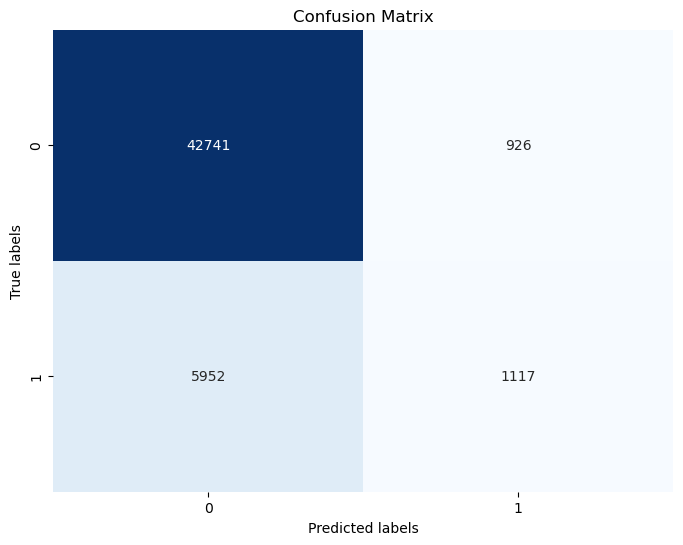

In [22]:
# Assuming y_test and y_pred are the true and predicted labels respectively
cm = confusion_matrix(y_test, y_pred_new)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The code below defines a function `post_tuning_evaluation` that evaluates the performance of a tuned model before and after hyperparameter tuning. Here's what it does:

1. It checks if the specified `model_name` has been tuned using `GridSearchCV` (`tuned_models_gs`).

2. It calculates the pre-tuning cross-validation score (`pre_tuning_cv_score`) and the post-tuning cross-validation score (`post_tuning_cv_score`) for the specified model.

3. It calculates pre-tuning and post-tuning metric scores such as accuracy, precision, sensitivity (recall), specificity, and F1-score using the tuned model on the test dataset (`X_test`).

4. It calculates the percentage change in cross-validation score, accuracy, precision, sensitivity, specificity, and F1-score before and after tuning.

5. It formats the evaluation results into a table (`table_data`) using the `tabulate` function.

6. It prints the model name along with the pre-tuning vs. post-tuning evaluation results in tabular format.

In [23]:
def post_tuning_evaluation(model_name):
    if model_name not in tuned_models_gs:
        print(f"No tuning performed for {model_name}")
        return
    
    # Get pre-tuning cv score
    pre_tuning_cv_score = baseline_cv_scores[model_name]['CV Score']
    
    # Get post-tuning cv score
    post_tuning_cv_score = cross_val_score(tuned_models_gs[model_name], X_train, y_train, cv=5).mean()

    # Get pre-tuning metric scores
    pre_tuning_metric_scores = baseline_metric_scores[model_name]
    
    # Get post-tuning metric scores
    post_tuning_model = tuned_models_gs[model_name]
    y_pred_new = post_tuning_model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_new).ravel()
    post_tuning_accuracy = accuracy_score(y_test, y_pred_new)
    post_tuning_precision = precision_score(y_test, y_pred_new)
    post_tuning_sensitivity = recall_score(y_test, y_pred_new)
    post_tuning_specificity = tn / (tn + fp)
    post_tuning_f1 = f1_score(y_test, y_pred_new)
    
    # Calculate percentage change
    percentage_change = ((post_tuning_cv_score - pre_tuning_cv_score) / pre_tuning_cv_score) * 100
    percentage_change_accuracy = ((post_tuning_accuracy - pre_tuning_metric_scores['Accuracy']) / pre_tuning_metric_scores['Accuracy']) * 100
    percentage_change_precision = ((post_tuning_precision - pre_tuning_metric_scores['Precision']) / pre_tuning_metric_scores['Precision']) * 100
    percentage_change_sensitivity = ((post_tuning_sensitivity - pre_tuning_metric_scores['Sensitivity']) / pre_tuning_metric_scores['Sensitivity']) * 100
    percentage_change_f1 = ((post_tuning_f1 - pre_tuning_metric_scores['F1-Score']) / pre_tuning_metric_scores['F1-Score']) * 100
    percentage_change_specificity = ((post_tuning_specificity - pre_tuning_metric_scores['Specificity']) / pre_tuning_metric_scores['Specificity']) * 100
    
    # Create table data
    table_data = [
        ["Metric", "Pre-Tuning Score", "Post-Tuning Score", "Percentage Change"],
        ["Cross-Validation", pre_tuning_cv_score, post_tuning_cv_score, percentage_change],
        ["Accuracy", pre_tuning_metric_scores['Accuracy'], post_tuning_accuracy, percentage_change_accuracy],
        ["Precision", pre_tuning_metric_scores['Precision'], post_tuning_precision, percentage_change_precision],
        ["Sensitivity", pre_tuning_metric_scores['Sensitivity'], post_tuning_sensitivity, percentage_change_sensitivity],
        ["Specificity", pre_tuning_metric_scores['Specificity'], post_tuning_specificity, percentage_change_specificity],
        ["F1-Score", pre_tuning_metric_scores['F1-Score'], post_tuning_f1, percentage_change_f1]
    ]
    
    # Print table
    print(f"{model_name} Pre- vs. Post-Tuning Evaluation")
    print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

# Example usage
post_tuning_evaluation('Gradient Boost')

Gradient Boost Pre- vs. Post-Tuning Evaluation
+------------------+--------------------+---------------------+---------------------+
| Metric           |   Pre-Tuning Score |   Post-Tuning Score |   Percentage Change |
+==================+====================+=====================+=====================+
| Cross-Validation |           0.857781 |            0.866702 |             1.04004 |
+------------------+--------------------+---------------------+---------------------+
| Accuracy         |           0.826652 |            0.864436 |             4.57071 |
+------------------+--------------------+---------------------+---------------------+
| Precision        |           0.396448 |            0.546745 |            37.9108  |
+------------------+--------------------+---------------------+---------------------+
| Sensitivity      |           0.467393 |            0.158014 |           -66.1925  |
+------------------+--------------------+---------------------+---------------------+
| Speci

While there are improvements in `Accuracy`, `Precision` and `Specificity` scores, there is a significant negative impact on `Sensitivity` and `F1-Score` even with hyperparameter tuning, where `Sensitivity` was chosen as the metric to be maximised.

Despite attempts to address class imbalance and to improve `Precision`, `Sensitivity` and `F1-Score` of the Gradient Boost model via hyperparameter tuning, the scores remained low (less than 0.55) after tuning.

Therefore, we will train our models using the 50-50 dataset (Part 2A) where the performance metrics for all 6 models are significantly higher, even before tuning.